# Risk Analysis for DonKa Detector

Initial tests to determine potential challenges for the DonKa Detector

## Assessments

 1. Options for audio streaming
 2. Optimizing for Digital Signal Processing (DSP)
    1. Might want to pivot away from Python. 
    2. First, see how intensive operations are involving NumPy
 3. High-accuracy detection options
    1. Create datasets of pencil taps and Tatacon usage
    2. Detection using statistics
       1. Quantile analysis of the DFT
       2. Mean/Median-based detectuib

### 1. Options for audio streaming

In [ ]:
import pyaudio
import wave
import math

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 512
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

In [ ]:
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

In [ ]:
import time

device_index = 2
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = device_index,
                frames_per_buffer=CHUNK)

Recordframes = []
 
for i in range(0, math.ceil(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    Recordframes.append(data)

In [ ]:
stream.stop_stream()
stream.close()
audio.terminate()

In [ ]:
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(Recordframes))
waveFile.close()

### 2. Options for DSP

Use the same setup as for assessment (1), but see how quickly we can perform operations using NumPy and librosa

https://librosa.org/doc/latest/generated/librosa.effects.percussive.html#librosa.effects.percussive

#### Assessment of NumPy

In [13]:
import pyaudio
import wave
import math

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 4096
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Microphone (Realtek(R) Audio)
Input Device id  2  -  Headset (2- WH-CH720N)


We can play around with different rates and chunk sizes

In [14]:
import time
import numpy as np

device_index = 2
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = device_index,
                frames_per_buffer=CHUNK)

audio_arr = np.zeros((RATE, ))
np_time = 0
 
for i in range(0, math.ceil(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    start=time.time()
    # Shift Audio array
    audio_arr[:-CHUNK] = audio_arr[CHUNK:] / (1 << 15)
    audio_arr[-CHUNK:] = np.frombuffer(data, dtype=np.int16)
    np_time += time.time()-start

stream.stop_stream()
stream.close()
audio.terminate()

np_time/RECORD_SECONDS

0.0008951663970947265

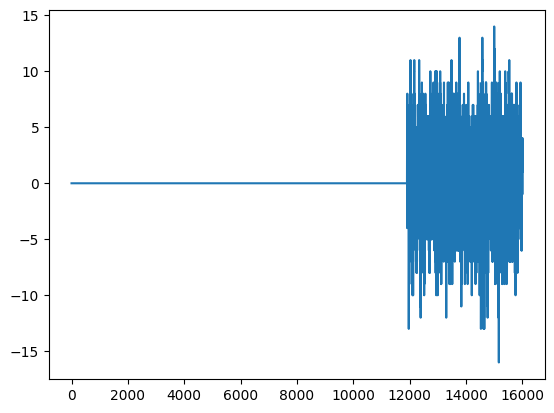

In [15]:
import matplotlib.pyplot as plt

plt.plot(audio_arr)

#### Assessment of Librosa

In [72]:
import pyaudio
import wave
import math

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 2048
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Microphone (Realtek(R) Audio)
Input Device id  2  -  Headset (2- WH-CH720N)


In [73]:
import time
import numpy as np
import librosa.onset

device_index = 2
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = device_index,
                frames_per_buffer=CHUNK)

audio_arr = np.zeros((RATE*RECORD_SECONDS + CHUNK, ))
onsets = np.array([audio_arr.shape[0]-1])
np_time,librosa_time = 0,0

def retrieve_onsets(audio_arr: np.ndarray) -> np.ndarray:
    this_onsets = librosa.onset.onset_detect(y=audio_arr, sr=RATE, units="samples")
    cleaned_onsets = []
    for onset in this_onsets:
        if np.max(np.abs(audio_arr[onset - RATE // 20:onset + RATE // 20])) >= 500 / (1 << 15):
            cleaned_onsets.append(int(onset))
    return np.array(cleaned_onsets)
 
for i in range(0, math.ceil(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    start=time.time()
    # Shift Audio array
    audio_arr[:-CHUNK] = audio_arr[CHUNK:]
    audio_arr[-CHUNK:] = np.frombuffer(data, dtype=np.int16) / (1 << 15)
    np_time += time.time()-start
    onsets -= CHUNK

    # Librosa onsets
    this_audio = audio_arr[int(onsets[-1]):]
    if len(this_audio) == 0 or np.max(np.abs(this_audio)) * (1 << 15) < 500: continue

    start = time.time()
    this_onsets = retrieve_onsets(this_audio)
    librosa_time += time.time() - start

    onsets = np.concatenate((onsets, this_onsets+onsets[-1] + RATE//20))


stream.stop_stream()
stream.close()
audio.terminate()

np_time/RECORD_SECONDS,librosa_time/RECORD_SECONDS

c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1921
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1633
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1345
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1569
  warnings.warn(
c:\Users\angel\anaconda3\envs\donka-detector\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(


(0.0012026309967041015, 0.008327245712280273)

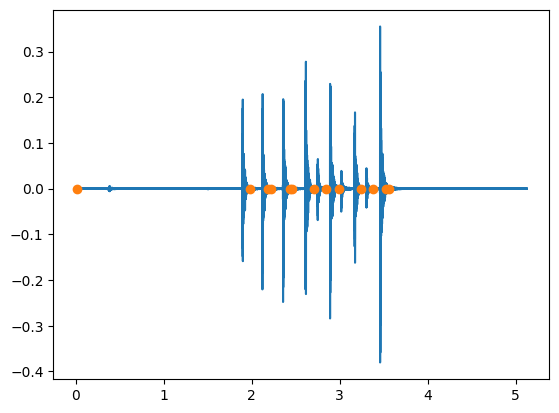

In [75]:
import librosa.onset
import matplotlib.pyplot as plt

plt.plot([i/RATE for i in range(audio_arr.shape[0])],audio_arr)
plt.plot(onsets/RATE, [0]*len(onsets), 'o')
#plt.plot(np.concatenate((onsets-RATE//20, onsets+RATE//20))/RATE, [0] * 2 * len(onsets), 'ro')
#plt.xlim(0.4, 2.25)
plt.show()

### Detection Options

#### Dataset Loading

In [1]:
import time
import numpy as np
import librosa

audio_arr, sr = librosa.load("../../datasets/pencil/data.mp3", sr=16000)

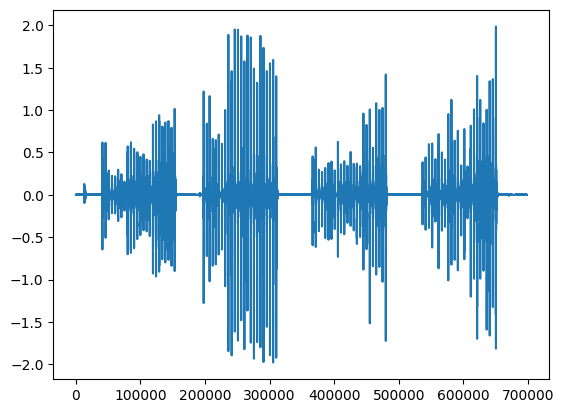

In [2]:
import matplotlib.pyplot as plt
import librosa.onset

plt.plot(np.array(range(len(audio_arr))), audio_arr)
plt.show()

0.0011515501


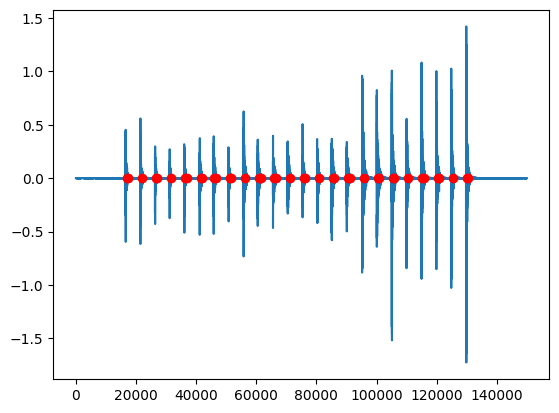

In [3]:
r_don = audio_arr[20000:175000]
l_don = audio_arr[175000:350000]
r_ka = audio_arr[350000:500000]
l_ka = audio_arr[500000:]

plt.plot(np.array(range(len(r_ka))), r_ka)
onsets = librosa.onset.onset_detect(y=r_ka, sr=sr, units="samples")
plt.plot(onsets, [0] * len(onsets), 'ro')
print(np.max(r_ka[-10000:]))
plt.show()

#### Data Preprocessing

Need to test how viable it is to retrieve the DonKa data from users

[np.float32(0.64505476), np.float32(0.613189), np.float32(0.28890455), np.float32(0.22408126), np.float32(0.21983871), np.float32(0.30943438), np.float32(0.26573277), np.float32(0.18599263), np.float32(0.70138985), np.float32(0.6855728), np.float32(0.63185906), np.float32(0.5226071), np.float32(0.4762862), np.float32(0.47798008), np.float32(0.43107024), np.float32(0.48692116), np.float32(0.92879105), np.float32(0.964336), np.float32(0.9390942), np.float32(0.8037646), np.float32(0.8534812), np.float32(0.86956406), np.float32(0.83813184), np.float32(1.0140125)]
[np.float32(0.18599263), np.float32(0.21983871), np.float32(0.22408126), np.float32(0.26573277), np.float32(0.28890455), np.float32(0.30943438), np.float32(0.43107024), np.float32(0.4762862), np.float32(0.47798008), np.float32(0.48692116), np.float32(0.5226071), np.float32(0.613189), np.float32(0.63185906), np.float32(0.64505476), np.float32(0.6855728), np.float32(0.70138985), np.float32(0.8037646), np.float32(0.83813184), np.floa

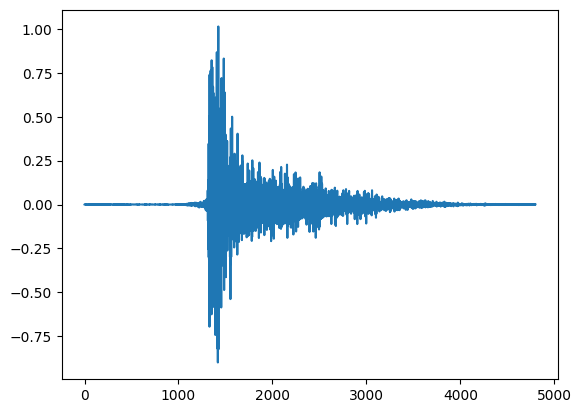

(24,
 [4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800,
  4800],
 [np.float32(0.64505476),
  np.float32(0.613189),
  np.float32(0.28890455),
  np.float32(0.22408126),
  np.float32(0.21983871),
  np.float32(0.30943438),
  np.float32(0.26573277),
  np.float32(0.18599263),
  np.float32(0.70138985),
  np.float32(0.6855728),
  np.float32(0.63185906),
  np.float32(0.5226071),
  np.float32(0.4762862),
  np.float32(0.47798008),
  np.float32(0.43107024),
  np.float32(0.48692116),
  np.float32(0.92879105),
  np.float32(0.964336),
  np.float32(0.9390942),
  np.float32(0.8037646),
  np.float32(0.8534812),
  np.float32(0.86956406),
  np.float32(0.83813184),
  np.float32(1.0140125)])

In [4]:
from typing import List
def get_notes(array: np.ndarray, frame_left: int=1600, frame_right: int=3200) -> List[np.ndarray]:
    ret: List[np.ndarray] = []
    max_amp: List[int] = []
    
    onsets = librosa.onset.onset_detect(y=array, sr=sr, units="samples")
    last_onset = -frame_right
    for onset in onsets:
        if onset <= last_onset + frame_right:
            last_onset = onset
            continue
        wav = array[max(onset-frame_left, 0):min(onset+frame_right,len(array))]
        if wav.shape[0]==0:
            continue
        ret.append(wav)
        max_amp.append(np.max(np.abs(wav)))
        last_onset = onset
        
    amp_lowerbound: int = sorted(max_amp)[-24]
    print(max_amp)
    print(sorted(max_amp))
    print(onsets)
    return [wav for idx,wav in enumerate(ret) if max_amp[idx] >= amp_lowerbound - 1e-9]

result = get_notes(r_don)
plt.plot(result[-1])
plt.show()
len(result),[i.shape[0] for i in result],[np.max(np.abs(i)) for i in result]

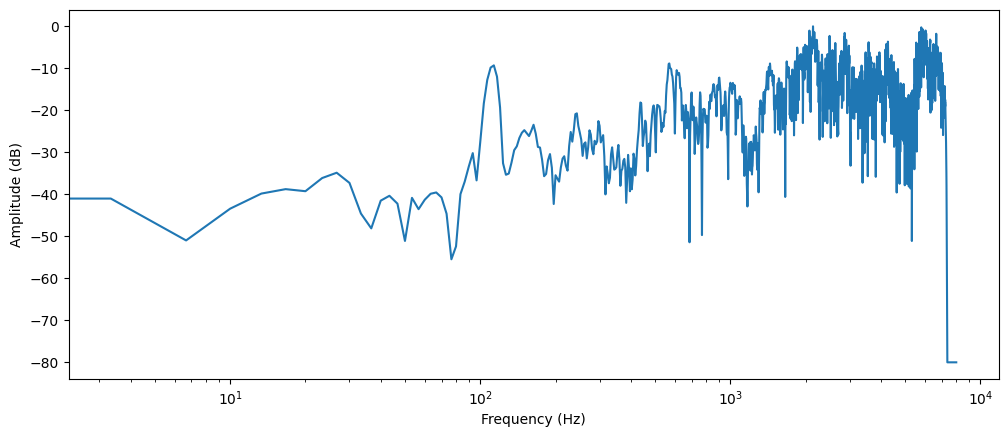

In [5]:
dft_input = result[0]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sr, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

In [6]:
r_don,l_don,r_ka,l_ka=[get_notes(i) for i in [r_don,l_don,r_ka,l_ka]]

[np.float32(0.64505476), np.float32(0.613189), np.float32(0.28890455), np.float32(0.22408126), np.float32(0.21983871), np.float32(0.30943438), np.float32(0.26573277), np.float32(0.18599263), np.float32(0.70138985), np.float32(0.6855728), np.float32(0.63185906), np.float32(0.5226071), np.float32(0.4762862), np.float32(0.47798008), np.float32(0.43107024), np.float32(0.48692116), np.float32(0.92879105), np.float32(0.964336), np.float32(0.9390942), np.float32(0.8037646), np.float32(0.8534812), np.float32(0.86956406), np.float32(0.83813184), np.float32(1.0140125)]
[np.float32(0.18599263), np.float32(0.21983871), np.float32(0.22408126), np.float32(0.26573277), np.float32(0.28890455), np.float32(0.30943438), np.float32(0.43107024), np.float32(0.4762862), np.float32(0.47798008), np.float32(0.48692116), np.float32(0.5226071), np.float32(0.613189), np.float32(0.63185906), np.float32(0.64505476), np.float32(0.6855728), np.float32(0.70138985), np.float32(0.8037646), np.float32(0.83813184), np.floa

#### Summary Statistics

Analyze if there are differences in DFT between each note, looking at the mean squared differences

In [7]:

all_notes = r_don + l_don + r_ka + l_ka

diff = np.zeros((len(all_notes), len(all_notes)))

for i,notei in enumerate(all_notes):
    window = np.hanning(len(notei))
    windowed_input = notei * window
    dfti = np.fft.rfft(windowed_input)
    dfti = np.abs(dfti)
    dfti /= np.sum(dfti)
    for j,notej in enumerate(all_notes):
        window = np.hanning(len(notej))
        windowed_input = notej * window
        dftj = np.fft.rfft(windowed_input)
        dftj = np.abs(dftj)
        dftj /= np.sum(dftj)
        diff[i][j] = np.mean((dfti - dftj)**2)

In [8]:
len(all_notes)

96

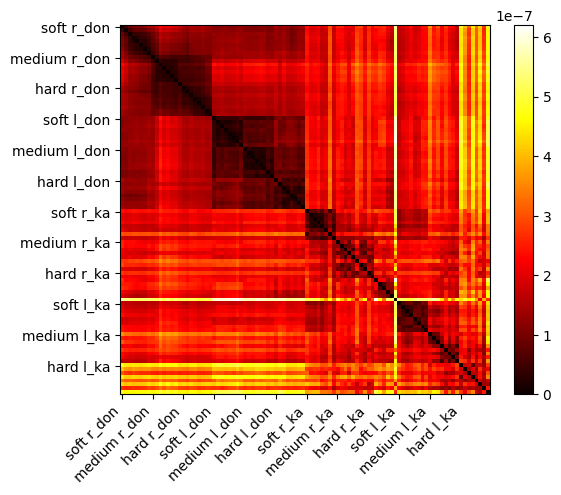

In [9]:
plt.imshow(diff, cmap="hot", interpolation="nearest")
plt.xticks(range(0,len(all_notes), 8), 
           ["soft r_don", "medium r_don", "hard r_don",
            "soft l_don", "medium l_don", "hard l_don",
            "soft r_ka", "medium r_ka", "hard r_ka",
            "soft l_ka", "medium l_ka", "hard l_ka",], 
           rotation=45, ha="right")
plt.yticks(range(0,len(all_notes), 8), 
           ["soft r_don", "medium r_don", "hard r_don",
            "soft l_don", "medium l_don", "hard l_don",
            "soft r_ka", "medium r_ka", "hard r_ka",
            "soft l_ka", "medium l_ka", "hard l_ka",])
plt.colorbar()
plt.show()

Darker color: Similar

Lighter color: Different

#### Detection

Create a 50/50 data split for all DonKa classes - soft/medium/hard RDon/LDon/RKa/LKa

Create note charts synthetically and determine how easily Dons and Kas can be identified. Make sure identification can happen quickly.


Something to keep in mind: Getting the side wrong is not devastating, but getting the note wrong is. I still want to differentiate between them.
Also, this formulation does not consider hitting on both sides, so this is playing under arcade rules

In [10]:
train_x = r_don[::2] + r_ka[::2] + l_don[::2] + l_ka[::2]
train_y = np.concatenate(
    (
        np.zeros((len(r_don[::2]),4)) + np.array([1,0,0,0]),
        np.zeros((len(r_ka[::2]),4))  + np.array([0,0,1,0]),
        np.zeros((len(l_don[::2]),4)) + np.array([0,1,0,0]),
        np.zeros((len(l_ka[::2]),4))  + np.array([0,0,0,1]),
    )
)
test_x = r_don[1::2] + r_ka[1::2] + l_don[1::2] + l_ka[1::2]
test_y = np.concatenate(
    (
        np.zeros((len(r_don[1::2]),4)) + np.array([1,0,0,0]),
        np.zeros((len(r_ka[1::2]),4))  + np.array([0,0,1,0]),
        np.zeros((len(l_don[1::2]),4)) + np.array([0,1,0,0]),
        np.zeros((len(l_ka[1::2]),4))  + np.array([0,0,0,1]),
    )
)

In [11]:
from typing import Tuple
import random

def create_random_chart(x: List[np.ndarray], y: np.ndarray, noise_std: float=0.01, note_rate: float=2, sr:int = sr, time_s: float = 5, frame_left: int=1600, frame_right: int=3200) -> Tuple[np.ndarray, np.ndarray]:
    # x: Arrays are wave forms
    # y: (len(x), 4): Class of each wave form in x
    # noise_std: Standard deviation of white noise added to signal
    # note_rate: notes per second
    # sr: sample rate
    # time_s: length of chart in seconds
    
    assert len(x) == len(y)
    assert y.shape==(len(x), 4)
    assert False not in [len(i.shape) == 1 for i in x]

    total_samples = int(sr*time_s)

    audio = np.random.normal(scale=noise_std,size=(total_samples,))
    chart = np.zeros((total_samples,4))

    samples_bw = int(sr / note_rate)

    waveforms_class: List[List[np.ndarray]] = [[],[],[],[]]

    for donka,cls in zip(x,y):
        cls = np.argmax(cls)
        waveforms_class[cls].append(donka)

    for i in range(samples_bw, total_samples, samples_bw):
        note = np.random.randint(0,5)
        if note == 4:
            continue

        select_waveform = random.choice(waveforms_class[note])
        if i + frame_right >= total_samples:
            break
        chart[i][note] = 1
        audio[i-frame_left:i+frame_right] += select_waveform
    

    return audio,chart

audio,chart = create_random_chart(train_x, train_y, note_rate=8)

In [12]:
from IPython.display import Audio
Audio(audio, rate=sr)

Visualize spectrogram and chart

[0.125, 0.5, 0.625, 0.875, 1.25, 1.375, 1.625, 1.875, 2.0, 2.125, 2.25, 2.375, 2.625, 2.75, 2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.625, 4.0, 4.125, 4.25, 4.375, 4.625, 4.75]
[0.128 0.16  0.512 0.544 0.64  0.672 0.864 0.896 1.248 1.28  1.408 1.632
 1.664 1.888 1.92  2.048 2.144 2.272 2.4   2.656 2.784 2.88  2.912 3.008
 3.136 3.168 3.296 3.424 3.648 4.    4.032 4.128 4.16  4.256 4.288 4.384
 4.608 4.64  4.768 4.8  ]


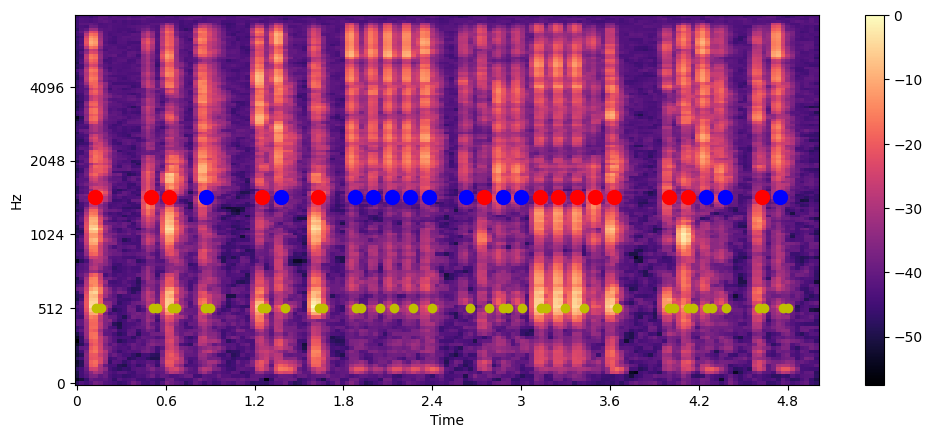

In [13]:
import librosa.feature

S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)

chart_sparse = [idx/sr for idx,i in enumerate(chart) if np.max(i) > 0.5]
chart_sparse_don = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) >= 2]
chart_sparse_ka  = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) < 2]

plt.plot([idx/sr for i,idx in chart_sparse_don], [1024 * (2**.5)] * len(chart_sparse_don), "ro", markersize=10)
plt.plot([idx/sr for i,idx in chart_sparse_ka], [1024 * (2**.5)] * len(chart_sparse_ka), "bo", markersize=10)

onsets = librosa.onset.onset_detect(y=audio, sr=sr, units="time")

plt.plot(onsets, [512]*len(onsets), "yo")

print(chart_sparse)
print(onsets)
plt.colorbar()
plt.show()

Now that charts can be generated, let's see if we can accurately detect dons and kas using test notes!

##### K-NN

Use the K most similar notes in the train set for prediction|

Define predictive model: Training process only involves giving the train notes and labels to the model

In [ ]:
def compute_mel_rep(note: np.ndarray) -> np.ndarray:
    return librosa.feature.melspectrogram(y=note, sr=sr, n_mels=128, fmax=8000)

def note_similarity_score(note1: np.ndarray, note2: np.ndarray, normalize1: bool=False, normalize2: bool=False, note1_mel: bool=False, note2_mel: bool=False) -> float:
    if not note1_mel:
        note1 = compute_mel_rep(note1)

    if not note2_mel:
        note2 = compute_mel_rep(note2)

    if normalize1: note1 /= np.sum(note1)
    if normalize2: note2 /= np.sum(note2)

    return np.mean((note1 - note2) ** 2)
    

def retrieve_chart(audio: np.ndarray, sr: int, train_x: List[np.ndarray], train_y: np.ndarray, frame_left: int=1600, frame_right: int=3200, K=5, normalize=True) -> List[Tuple[int, int]]:
    onsets = librosa.onset.onset_detect(y=audio, sr=sr, units="samples")

    train_mel: List[np.ndarray] = [compute_mel_rep(note) for note in train_x]
    if normalize: train_mel: List[np.ndarray] = [i/np.sum(i) for i in train_mel]

    last_onset = -frame_left

    answer = []

    for onset in onsets:
        if onset < last_onset + frame_left: continue

        note = audio[onset-frame_left:onset+frame_right]
        if note.shape != (frame_left + frame_right,) or np.max(audio) < np.min(np.max(train_x, axis=1)):
            continue
        note_mel = compute_mel_rep(note)
        if normalize: note_mel /= np.sum(note_mel)

        # Find K most similar notes
        # similarity, class
        best: List[Tuple[float, int]] = [(1e9, 4)] * K

        for note,cls in zip(train_mel, train_y):

            sim = note_similarity_score(note, note_mel, note1_mel=True, note2_mel=True)
            result = (sim, np.argmax(cls))
            if result < best[-1]:
                best[-1] = result
            best.sort()

        # Vote system
        votes = [0,0,0,0]
        for item,cls in best:
            votes[cls] += 1

        if votes[0] + votes[1] > votes[2] + votes[3]:
            answer.append((onset, np.argmax(votes[:2])))
        else:
            answer.append((onset, np.argmax(votes[2:]) + 2))
        last_onset = onset
    return answer

pred = retrieve_chart(audio, sr, train_x, train_y)

Test how well this works on a single example

In [15]:
audio,chart = create_random_chart(test_x, test_y, note_rate=5)

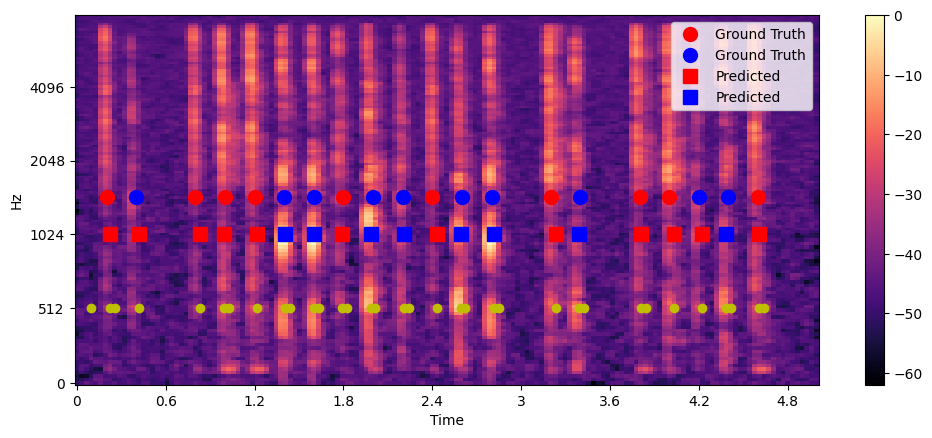

In [16]:
import librosa.feature

pred = retrieve_chart(audio, sr, train_x, train_y, K=7, normalize=False)

S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)

chart_sparse = [idx/sr for idx,i in enumerate(chart) if np.max(i) > 0.5]
chart_sparse_ka  = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) >= 2]
chart_sparse_don = [(np.argmax(i), idx) for idx,i in enumerate(chart) if np.max(i) > 0.5 and np.argmax(i) < 2]
pred_don = [idx/sr for idx,i in pred if i < 2]
pred_ka = [idx/sr for idx,i in pred if i >= 2 and i < 4]

plt.plot([idx/sr for i,idx in chart_sparse_don], [1024 * (2**.5)] * len(chart_sparse_don), "ro", markersize=10, label="Ground Truth")
plt.plot([idx/sr for i,idx in chart_sparse_ka], [1024 * (2**.5)] * len(chart_sparse_ka), "bo", markersize=10, label="Ground Truth")
plt.plot([t for t in pred_don], [1024] * len(pred_don), "rs", markersize=10, label="Predicted")
plt.plot([t for t in pred_ka], [1024] * len(pred_ka), "bs", markersize=10, label="Predicted")

onsets = librosa.onset.onset_detect(y=audio, sr=sr, units="time")

plt.plot(onsets, [512]*len(onsets), "yo")

plt.legend()

plt.colorbar()
plt.show()

Evaluations based on Levenshtein edit distance.

I will assume that note positions are accurately determined: This is one of the limitations of the metric. But I don't expect positions are an issue based on my previous assessments. Additionally, for any delay, the user will provide an offset in-game.

This maps to every miss case: Missing from choosing the wrong note, missing from excluding/including a note

In [17]:
from tqdm import tqdm
from Levenshtein import distance as levenshtein_distance

experiments: List[Tuple[int,float]] = [ # Number of examples, note_rate
    (10, 1),
    (10, 1.5),
    (10, 2),
    (10, 2.5),
    (10, 3),
    (10, 4),
    (10, 5),
    (10, 6),
    (10, 7),
    (10, 8),
]

def evaluate(normalize: bool, K: int, verbose=True):
    # So datasets are the same per-evaluation
    np.random.seed(42)
    random.seed(42)


    hist = []

    total_base_distance = 0
    total_bin_distance = 0
    total_pred = 0

    for samples,note_rate in experiments:
        num_pred = 0
        base_l_distance = 0
        bin_l_distance = 0
        pbar = range(samples)
        if verbose:
            pbar = tqdm(range(samples), desc=f"Experiment {samples}-{note_rate}")
        for i in pbar:
            audio, chart_gt = create_random_chart(test_x, test_y, note_rate=note_rate, sr=sr)
            chart_gt_sparse = [np.argmax(i) for idx,i in enumerate(chart_gt) if np.max(i) > 0.5]
            
            chart_pred = retrieve_chart(audio, sr, train_x, train_y, K=K, normalize=normalize)
            chart_pred = [cls for onset,cls in chart_pred]
            base_l_distance += levenshtein_distance(chart_gt_sparse, chart_pred)

            chart_pred = [cls//2 for cls in chart_pred]
            chart_gt_sparse = [cls//2 for cls in chart_gt_sparse]
            bin_l_distance += levenshtein_distance(chart_gt_sparse, chart_pred)

            num_pred += len(chart_pred)
            if i==samples-1 and verbose:
                pbar.set_description(f"Experiment {samples}-{note_rate}, Base: ({base_l_distance},{num_pred}), Binary: ({bin_l_distance},{num_pred})")

        hist.append((base_l_distance, bin_l_distance, num_pred))

        total_base_distance += base_l_distance
        total_bin_distance += bin_l_distance
        total_pred += num_pred
    return (total_base_distance, total_bin_distance, total_pred),hist

Let's do a grid search for hyperparameters

In [18]:
hp = [
    [normalize, k]
    for k in range(1,6)
    for normalize in (True, False)
]

In [19]:
results = []
for normalize, k in hp:
    print(f"Hyperparameters: normalize={normalize}, K={k}")
    results.append(evaluate(normalize, k))

Hyperparameters: normalize=True, K=1


Experiment 10-4, Base: (14,154), Binary: (2,154): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
Experiment 10-5, Base: (30,183), Binary: (17,183): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]
Experiment 10-6, Base: (38,231), Binary: (19,231): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]
Experiment 10-7, Base: (54,264), Binary: (30,264): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]
Experiment 10-8, Base: (91,281), Binary: (58,281): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Hyperparameters: normalize=False, K=1


Experiment 10-4, Base: (31,154), Binary: (9,154): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]
Experiment 10-5, Base: (41,183), Binary: (15,183): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
Experiment 10-6, Base: (44,231), Binary: (12,231): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]
Experiment 10-7, Base: (60,264), Binary: (17,264): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
Experiment 10-8, Base: (74,281), Binary: (39,281): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Hyperparameters: normalize=True, K=2


Experiment 10-4, Base: (18,154), Binary: (2,154): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
Experiment 10-5, Base: (36,183), Binary: (17,183): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]
Experiment 10-6, Base: (45,231), Binary: (18,231): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]
Experiment 10-7, Base: (61,264), Binary: (27,264): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
Experiment 10-8, Base: (98,281), Binary: (55,281): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Hyperparameters: normalize=False, K=2


Experiment 10-5, Base: (35,183), Binary: (8,183): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]
Experiment 10-6, Base: (37,231), Binary: (11,231): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]
Experiment 10-7, Base: (40,264), Binary: (11,264): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]
Experiment 10-8, Base: (69,281), Binary: (36,281): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Hyperparameters: normalize=True, K=3


Experiment 10-4, Base: (17,154), Binary: (5,154): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]
Experiment 10-5, Base: (44,183), Binary: (29,183): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-6, Base: (43,231), Binary: (31,231): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-7, Base: (68,264), Binary: (42,264): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-8, Base: (107,281), Binary: (70,281): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Hyperparameters: normalize=False, K=3


Experiment 10-2.5, Base: (5,88), Binary: (3,88): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
Experiment 10-3, Base: (17,118), Binary: (10,118): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
Experiment 10-4, Base: (12,154), Binary: (8,154): 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
Experiment 10-5, Base: (19,183), Binary: (10,183): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]
Experiment 10-6, Base: (26,231), Binary: (13,231): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]
Experiment 10-7, Base: (30,264), Binary: (20,264): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
Experiment 10-8, Base: (54,281), Binary: (43,281): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Hyperparameters: normalize=True, K=4


Experiment 10-4, Base: (20,154), Binary: (4,154): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]
Experiment 10-5, Base: (48,183), Binary: (21,183): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-6, Base: (50,231), Binary: (24,231): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
Experiment 10-7, Base: (72,264), Binary: (36,264): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]
Experiment 10-8, Base: (108,281), Binary: (61,281): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Hyperparameters: normalize=False, K=4


Experiment 10-5, Base: (29,183), Binary: (8,183): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]
Experiment 10-6, Base: (36,231), Binary: (11,231): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]
Experiment 10-7, Base: (43,264), Binary: (18,264): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]
Experiment 10-8, Base: (81,281), Binary: (42,281): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Hyperparameters: normalize=True, K=5


Experiment 10-4, Base: (18,154), Binary: (6,154): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
Experiment 10-5, Base: (43,183), Binary: (29,183): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]
Experiment 10-6, Base: (48,231), Binary: (32,231): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]
Experiment 10-7, Base: (75,264), Binary: (54,264): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]
Experiment 10-8, Base: (104,281), Binary: (74,281): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Hyperparameters: normalize=False, K=5


Experiment 10-2.5, Base: (11,88), Binary: (7,88): 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]
Experiment 10-3, Base: (31,118), Binary: (11,118): 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]
Experiment 10-4, Base: (24,154), Binary: (9,154): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
Experiment 10-5, Base: (40,183), Binary: (14,183): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
Experiment 10-6, Base: (41,231), Binary: (15,231): 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]
Experiment 10-7, Base: (49,264), Binary: (22,264): 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
Experiment 10-8, Base: (86,281), Binary: (46,281): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [20]:
non_normalized = [(k, bin_d/total, hist) for (normalize,k),((base_d,bin_d,total),hist) in zip(hp,results) if not normalize]
normalized = [(k, bin_d/total, hist) for (normalize,k),((base_d,bin_d,total),hist) in zip(hp,results) if normalize]

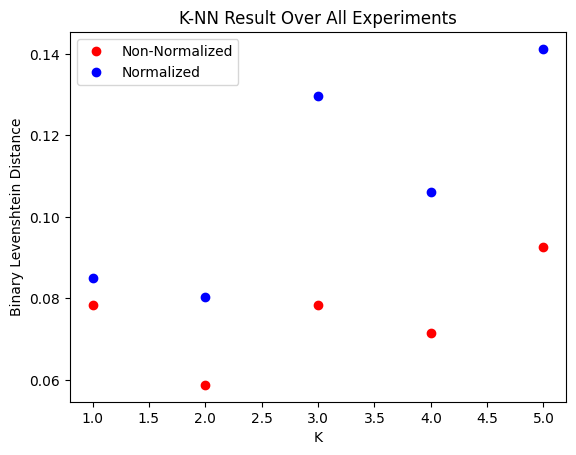

In [21]:
plt.plot([x[0] for x in non_normalized], [x[1] for x in non_normalized], 'ro', label="Non-Normalized")
plt.plot([x[0] for x in normalized], [x[1] for x in normalized], 'bo', label="Normalized")
plt.xlabel("K")
plt.ylabel("Binary Levenshtein Distance")
plt.title("K-NN Result Over All Experiments")
plt.legend()
plt.show()

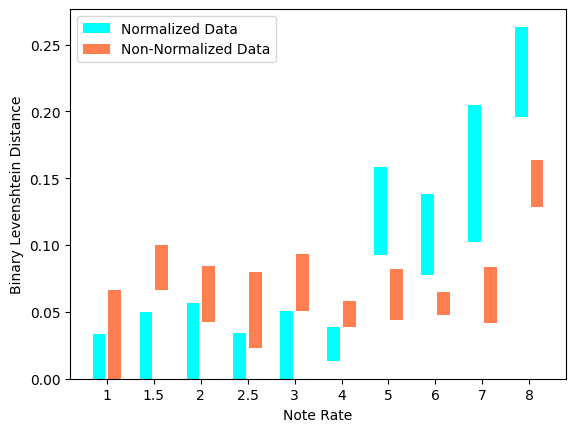

In [22]:
data = [[x[2][experiment][1]/x[2][experiment][2] for x in normalized] for experiment in range(len(experiments))]
plt.bar(np.array(range(len(experiments))) * 3, 
        np.ptp(data, axis=1), 
        bottom=np.min(data, axis=1), 
        color="aqua",
        label="Normalized Data")

data = [[x[2][experiment][1]/x[2][experiment][2] for x in non_normalized] for experiment in range(len(experiments))]
plt.bar(np.array(range(len(experiments))) * 3 + 1, 
        np.ptp(data, axis=1), 
        bottom=np.min(data, axis=1), 
        color="coral",
        label="Non-Normalized Data")

plt.legend()
plt.xticks(np.array(range(len(experiments))) * 3 + 0.5, [e[1] for e in experiments])
plt.xlabel("Note Rate")
plt.ylabel("Binary Levenshtein Distance")
    
plt.show()

An interesting trend emerged. For a note rate < 5, normalizing before computing similarity scores results in a better result, but for a note rate >= 5, it is better not to normalize. This suggests some ensemble method may result in optimal performance